### Importation de l'environnement de travail

#### Objectifs :
 - Analyser un bâtiment cubique avec 5 murs identiques et un mur transparent (fenêtre en verre), une infiltration d'air et un système CVC contrôlant la température de l'air intérieur.
 - Modéliser le transfert de chaleur dans le bâtiment par un circuit thermique.
 - Obtenir le modèle mathématique sous la forme d'un système d'équations algébriques différentielles (DAE) à partir du circuit thermique.
 - Transférez le système d'EAD dans une représentation de l'espace d'état.
 - Trouver la solution en régime permanent.
 - Simuler en utilisant les méthodes d'Euler pour l'intégration numérique...

In [15]:
import numpy as np
import pandas as pd

### Dimensions du problème et description du batiment étudié

<div>
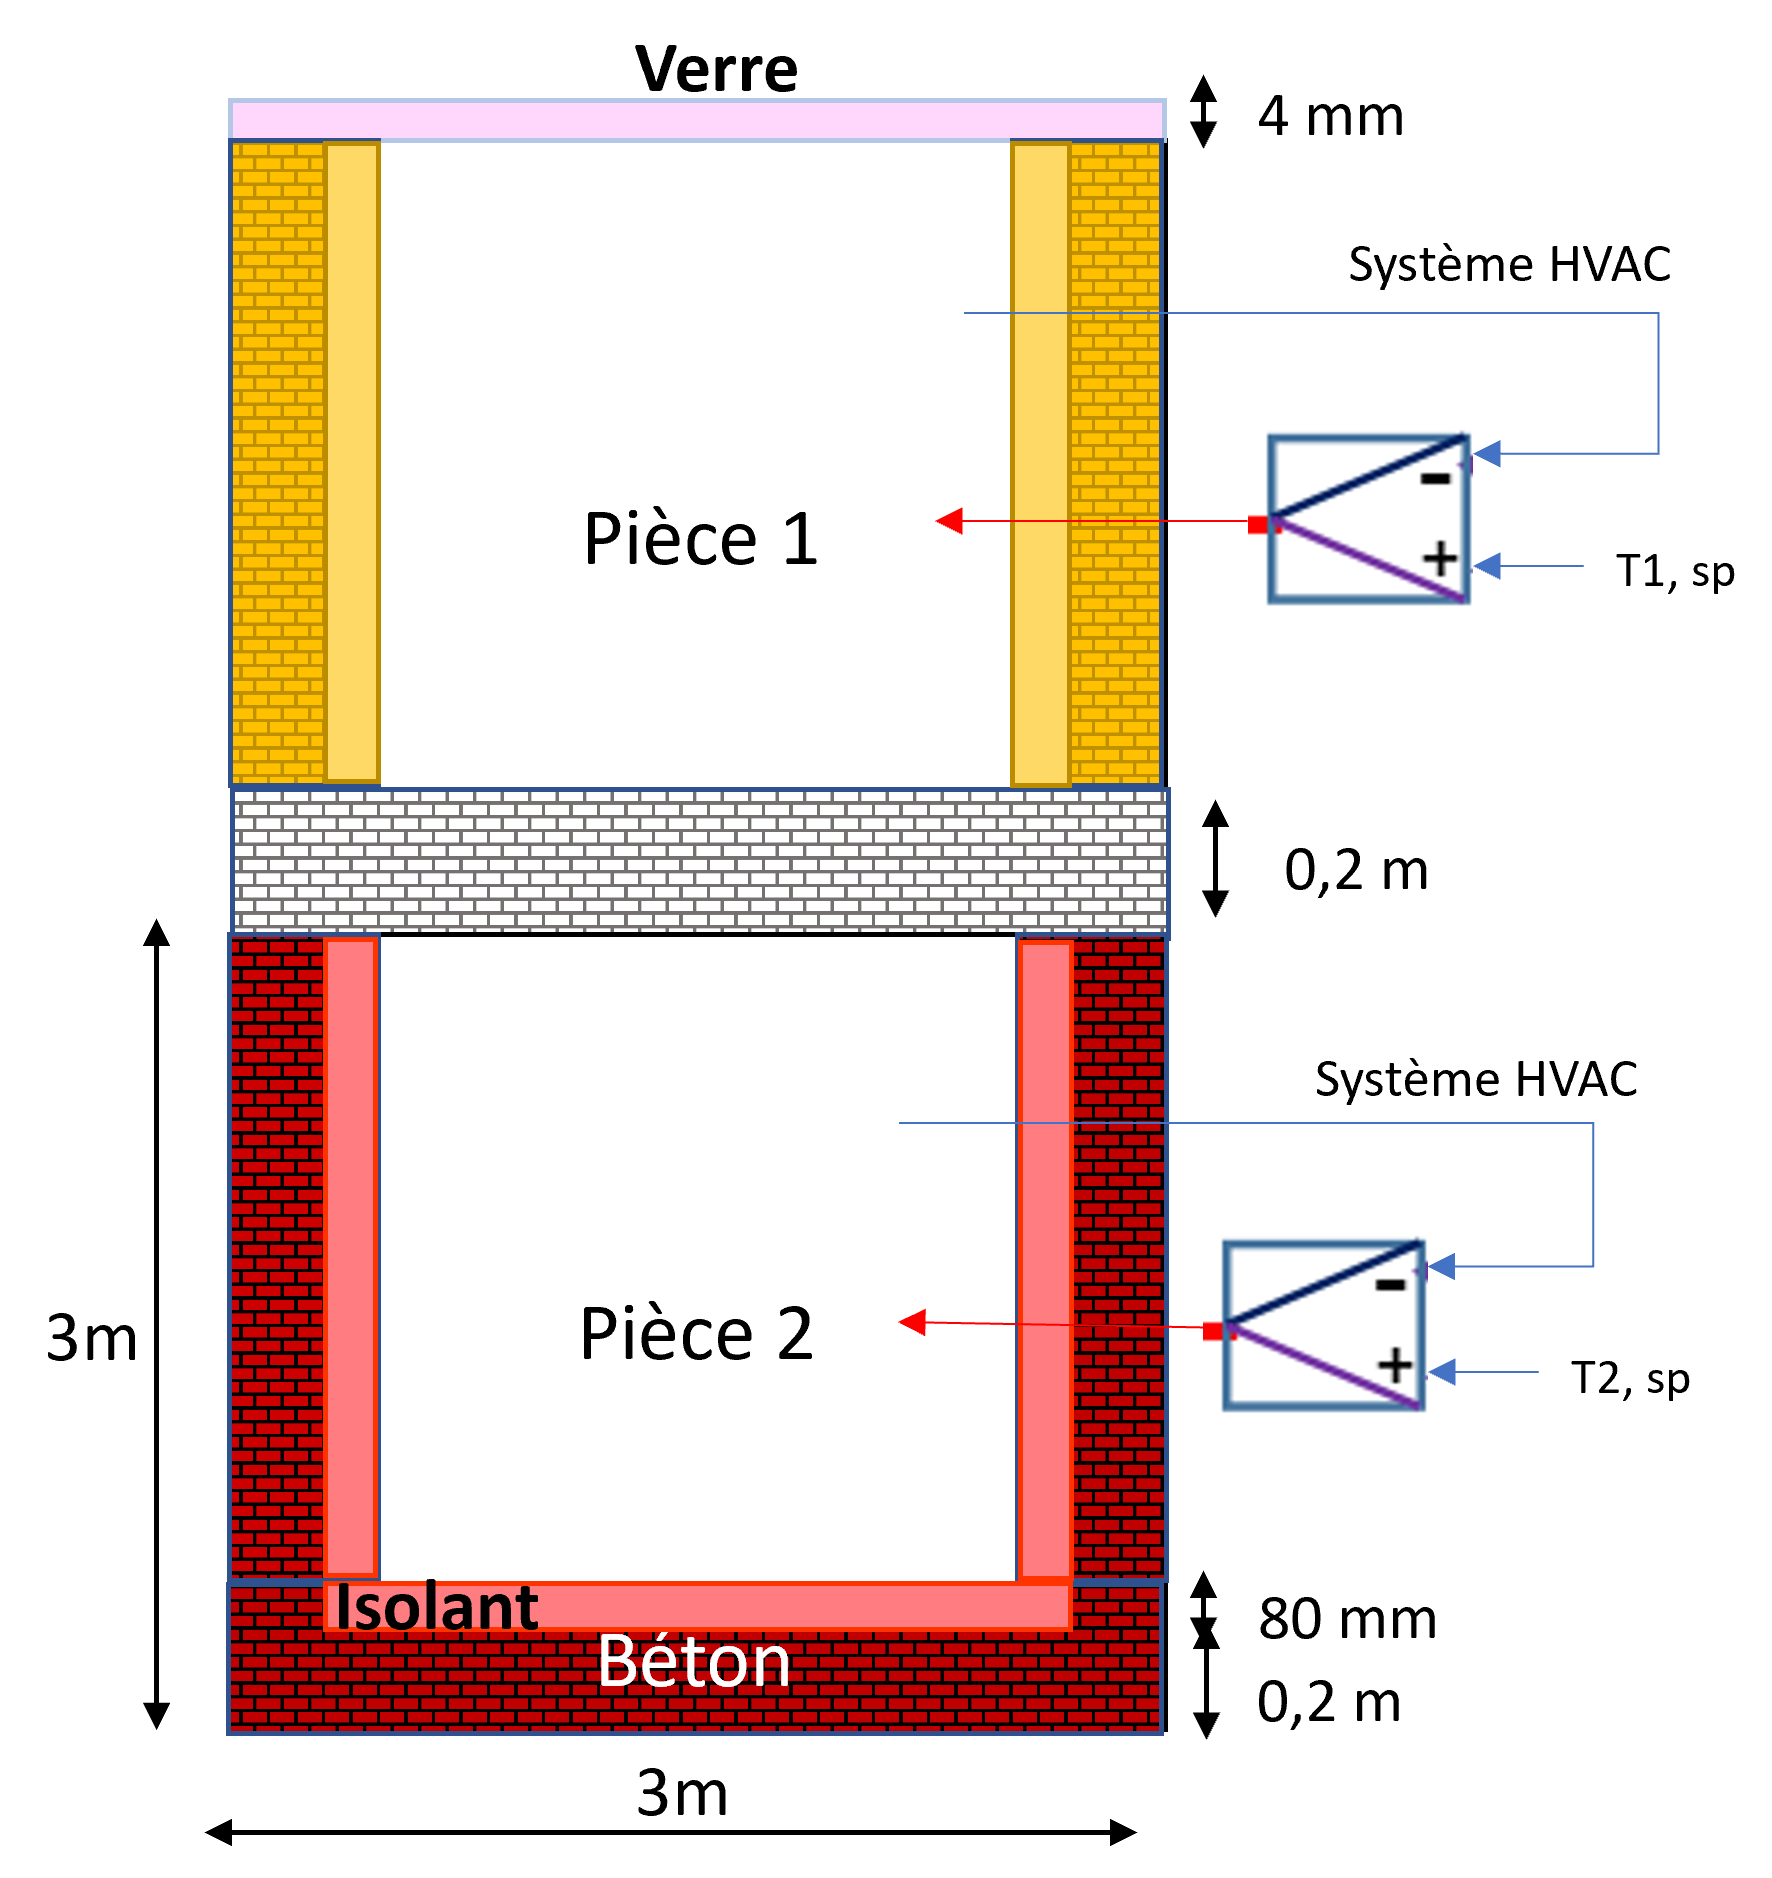
</div>

> Figure 1. Schéma de la situation étudiée, deux salles controllées de manière proportionelle par un systeme HVAC.

#### Dimensions du batiment et paramètres physiques

In [16]:
L = 6 #longueur
l = 3 #largeur
H = 3 #hauteur 
w1 = 0.20 #epaisseur des murs extérieurs
w2 = 0.10 #epaisseur des murs intérieurs
l_ambda = 1.70 #conductivité thermique beton
l_ambdag = 1.40 #conductivité thermique verre
E = 200 #rayonnement solaire
h_0 = 25 #coefficient de convection exterieur
h_i = 8 #coefficient de convection interieur

#### Temperatures et Conductances

In [17]:
T_ext = 5 #temperature exterieure
T_1 = 20 #temperature consigne salle 1
T_2 = 20 #temperature consigne salle 2

k_1 = 10**8 #parametre de controle salle 1
k_2 = 10**8 #parametre de controle salle 2

#definition des conductances des différents murs
Gi = h_i*H*(L + 2*l)
Gi2 = h_i*H*L
Gi3 = h_i*H*2*l
G0 = h_0*H*(L + 2*l)
G02 = h_0*H*L
G03 = h_0*H*2*l
G1 = (l_ambda/w1)*H*(L + 2*l)
G2 = (l_ambda/w2)*H*L
G3 = (l_ambda/w2)*H*2*l
Gg = (l_ambdag/w2)*H*L

### Modèle statique

#### Matrices

In [18]:
# Définition de la matrice d'incidence

A = np.zeros((9,5))
# definition coefficient 1
A[0,0] = A[1,2] = A[2,1] = A[3,2] = A[4,4] = A[5,3] = A[6,3] = A[7,2] = A[8,3] = 1

# definition coefficient -1
A[1,0] = A[3,1] = A[5,4] = A[6,2] = -1

print(A)

[[ 1.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1. -1.]
 [ 0.  0. -1.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]]


In [19]:
# Définition de la matrice température source

B = np.zeros((9,1))
B[0,0] = B[2,0] = B[4,0] = T_ext
B[7,0] = T_1
B[8,0] = T_2
print(B)

[[ 5.]
 [ 0.]
 [ 5.]
 [ 0.]
 [ 5.]
 [ 0.]
 [ 0.]
 [20.]
 [20.]]


In [20]:
# Définition de la matrice des flux extérieurs

F = np.zeros((5,1))
F[4,0] = E*(L + 2*l)*H 
F[0,0] = E*L*H 
F[1,0] = E*2*l*H 
print(F)

[[3600.]
 [3600.]
 [   0.]
 [   0.]
 [7200.]]


In [21]:
# Définition de la matrice des conductances

G = np.diag([G02, (Gi2*Gg)/(Gg + Gi2),G03, (Gi3*G3)/(G3 + Gi3), G0, (Gi*G1)/(G1 + Gi), (Gi2*G2)/(2*G2 + Gi2), k_1, k_2])
print(G)

[[4.50000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.16363636e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.50000000e+02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.79200000e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.00000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.48363636e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.82857143e+01 0.00000000e+00
  0.00000000e+00]
 [0.00

#### Loi des mailles et matrice de température

In [25]:
theta = np.linalg.inv((A.T@G@A))@(A.T@G@B + F)
theta

array([[14.18428818],
       [14.25098359],
       [19.99998904],
       [19.99999108],
       [13.99063349]])

In [23]:
E = -A@theta + B
E

array([[-9.18428818e+00],
       [-5.81570087e+00],
       [-9.25098359e+00],
       [-5.74900545e+00],
       [-8.99063349e+00],
       [-6.00935759e+00],
       [-2.04301911e-06],
       [ 1.09587217e-05],
       [ 8.91570264e-06]])

#### Matrice des Fluxs

In [26]:
Q = G@E
Q

array([[-4.13292968e+03],
       [-5.32929679e+02],
       [-4.16294261e+03],
       [-5.62942614e+02],
       [-8.09157014e+03],
       [-8.91570144e+02],
       [-1.19078828e-04],
       [ 1.09587217e+03],
       [ 8.91570264e+02]])

In [27]:
FluxPièce1= - Q[1] - Q[3] + Q[6]
FluxPièce2= - Q[5] - Q[6]

print(FluxPièce1, FluxPièce2)

[1095.87217429] [891.57026343]
